<a href="https://colab.research.google.com/github/NataliaBilash/network_scanner/blob/master/edr_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Препроцессинг

Целью препроцессинга является первичная обработка данных, в результате которой должен получится массив содержащий обработанные значения в диапазоне от 0 до 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from numpy.random import seed
import tensorflow as tf


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Чтобы масштабировать значения IP адреса в диапазон от 0 до 1 была создана функция scale_ip_addresses, получающая на вход IP адрес формата: доменное имя, ipv4 или ipv6, на выходе получается массив отмаштабированных значений. Получая ipv4 или ipv6 разбивает на октеты и делит на 255/65536, чтобы получились знеачения в нужном диапазоне.

In [3]:
import ipaddress

def scale_ip_addresses(ip_address):
    try:
        ip_obj = ipaddress.ip_address(ip_address) #создает объект IP-адреса
        if ip_obj.version == 4:
            octets = ip_address.split('.')
            scaled_octets = [int(octet) / 255.0 for octet in octets]
            return scaled_octets
        elif ip_obj.version == 6:
            groups = ip_obj.exploded.split(':')
            decimal_values = [int(group, 16) for group in groups]
            scaled_values = [(value + 1) / 65536.0 for value in decimal_values]
            return scaled_values
        else:
            ip_address_domain = socket.gethostbyname(ip_address)
            octets = ip_address_domain.split('.')
            scaled_octets = [int(octet) / 255.0 for octet in octets]
            return scaled_octets
    except ValueError:
        return [0, 0, 0, 0]

In [4]:
df = pd.read_csv('/content/drive/MyDrive/normal.csv')

#удаление ненужных столбцов
df = df.drop(columns = ['Info', 'No.'], axis=1)

#обработка пропущенных значений
df = df.replace("Missing", pd.NA)
df = df.replace("Offln", pd.NA)
df = df.dropna()

#создание столбцов вида "Название протокола" - наличие/отсутсвие 1/0
protocol_dummies = pd.get_dummies(df['Protocol'], prefix='Protocol')
protocol_dummies = protocol_dummies.astype(int)
df_encoded = pd.concat([df, protocol_dummies], axis=1)
df_encoded.drop(['Protocol'], axis=1, inplace=True)

#применение функции scale_ip_addresses
df_encoded['Source_scaled'] = df_encoded['Source'].apply(scale_ip_addresses)
df_encoded['Destination_scaled'] = df_encoded['Destination'].apply(scale_ip_addresses)

#дополнение ipv4 до длинны 8 октетов нулями и добаление столбцоы
df_encoded['Source_scaled'] = df_encoded['Source_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
df_encoded['Destination_scaled'] = df_encoded['Destination_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
source_octets_df = pd.DataFrame(df_encoded['Source_scaled'].tolist(), columns=[f'Source_Octet{i}' for i in range(1, 9)])
destination_octets_df = pd.DataFrame(df_encoded['Destination_scaled'].tolist(), columns=[f'Destination_Octet{i}' for i in range(1, 9)])

#соединение датафреймов и удаление ненужных столбцов
df_encoded = pd.concat([df_encoded, source_octets_df, destination_octets_df], axis=1)
df_encoded.drop(['Source_scaled', 'Destination_scaled', 'Source', 'Destination'], axis=1, inplace=True)
df_encoded.fillna(0, inplace=True)

df_encoded['Scaled_Time'] = (df_encoded['Time'] - df_encoded['Time'].shift(1)) / df_encoded['Time'].diff().max()
df_encoded['Scaled_Time'].fillna(0, inplace=True)
df_encoded.drop(['Time'], axis=1, inplace=True)

#нормализует значения с использованием Min-Max Scaling
scaler1 = MinMaxScaler()
df_encoded[['Length']] = scaler1.fit_transform(df_encoded[['Length']])
df_encoded[['Scaled_Time']] = scaler1.fit_transform(df_encoded[['Scaled_Time']])


print('Shape dataframe')
print(df_encoded.shape)


Shape dataframe
(1164779, 22)


In [ ]:
df_encoded

,Length,Protocol_ICMPv6,Protocol_MDNS,Protocol_Modbus/TCP,Protocol_TCP,Source_Octet1,Source_Octet2,Source_Octet3,Source_Octet4,Source_Octet5,...,Source_Octet8,Destination_Octet1,Destination_Octet2,Destination_Octet3,Destination_Octet4,Destination_Octet5,Destination_Octet6,Destination_Octet7,Destination_Octet8,Scaled_Time
0,0.000000,0,0,0,1,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,0.000000e+00
1,0.051613,0,0,0,1,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,5.079790e-04
2,0.051613,0,0,0,1,0.72549,0.686275,0.0,0.019608,0.0,...,0.0,0.72549,0.686275,0.0,0.011765,0.0,0.0,0.0,0.0,9.346893e-07
3,0.000000,0,0,0,1,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,5.903301e-07
4,0.077419,0,0,1,0,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,2.804068e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164774,0.051613,0,0,0,1,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,5.008705e-04
1164775,0.051613,0,0,0,1,0.72549,0.686275,0.0,0.019608,0.0,...,0.0,0.72549,0.686275,0.0,0.011765,0.0,0.0,0.0,0.0,9.838834e-07
1164776,0.000000,0,0,0,1,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,6.149272e-07
1164777,0.077419,0,0,1,0,0.72549,0.686275,0.0,0.011765,0.0,...,0.0,0.72549,0.686275,0.0,0.019608,0.0,0.0,0.0,0.0,1.094570e-05


#### Разделение на тестовые и тренировачные выборки

In [5]:
import numpy as np

split_index = int(len(df_encoded) * 0.8)  #80% для обучения

train = df_encoded.iloc[:split_index]
test = df_encoded.iloc[split_index:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (931823, 22)
Test dataset shape: (232956, 22)


Повторная нормализация нужна, чтобы обеспечить одинаковую шкалу значений на обеих выборках.

In [6]:
#нормализация данных
scaler2 = MinMaxScaler()
X_train = scaler2.fit_transform(train)
X_test = scaler2.transform(test)

#### Изменить форму входных данных для LSTM

Изменить форму нужно, так как на вход LSTM принимается 3D-тензор с формой (batch, timesteps, feature), где
batch: количество пакетов в наборе данных,
timesteps: количество временных шагов в пакете,
features: количество признаков в каждом временном шаге.

In [7]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (931823, 1, 22)
Test data shape: (232956, 1, 22)


## LSTM

Для модели LSTM создается начальный слой, где указывется количество временных щагов и количество признаков. Далее в кажом слое с нейронами есть функция dropout, которая помогает предотвратить переобучение, затушивая случайные нейроны в процессе обучения.

Слой RepeatVector нужен, чтобы данные восстанавливали то же измерение, что и исходные входные данные, то есть преобразование тензора функций из 1D в 2D так как для кодера-декодера входные данные сжимаются в один вектор признаков.

На выходном слое TimeDistributed применяет Dense к каждому пакету, который он получает в качестве входных данных.

In [ ]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2)(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False, dropout=0.2)(L1)
    #повторяет последний выходной вектор
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True, dropout=0.2)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

Далее создается модель автоэнкодера, экперементальным путем был выделен оптимизатор Adam с заданным коэффициентом скорости обучения 0,001
loss='mae' задает функцию потерь, MAE измеряет среднее абсолютное отклонение между фактическими и предсказанными значениями, также ослеживается
метрика accuracy

In [ ]:
from keras.optimizers import Adam

model = autoencoder_model(X_train)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 22)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 32)             7040      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 16)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             6272      
                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint

X_val = X_test
checkpoint = ModelCheckpoint('model_3.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
history = model.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), callbacks=[checkpoint]).history



Epoch 1/50
14557/14560 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.3516
Epoch 1: val_loss improved from inf to 0.00683, saving model to model_3.h5
14560/14560 [==============================] - 122s 8ms/step - loss: 0.0056 - accuracy: 0.3516 - val_loss: 0.0068 - val_accuracy: 0.2999
Epoch 2/50
    7/14560 [..............................] - ETA: 2:10 - loss: 0.0050 - accuracy: 0.1027

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14558/14560 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.3510
Epoch 2: val_loss improved from 0.00683 to 0.00664, saving model to model_3.h5
14560/14560 [==============================] - 112s 8ms/step - loss: 0.0054 - accuracy: 0.3511 - val_loss: 0.0066 - val_accuracy: 0.2999
Epoch 3/50
14560/14560 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.3460
Epoch 3: val_loss improved from 0.00664 to 0.00655, saving model to model_3.h5
14560/14560 [==============================] - 114s 8ms/step - loss: 0.0052 - accuracy: 0.3460 - val_loss: 0.0066 - val_accuracy: 0.2999
Epoch 4/50
14560/14560 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.3439
Epoch 4: val_loss improved from 0.00655 to 0.00642, saving model to model_3.h5
14560/14560 [==============================] - 117s 8ms/step - loss: 0.0052 - accuracy: 0.3439 - val_loss: 0.0064 - val_accuracy: 0.7998
Epoch 5/50
14556/14560 [============================>.] - ETA: 

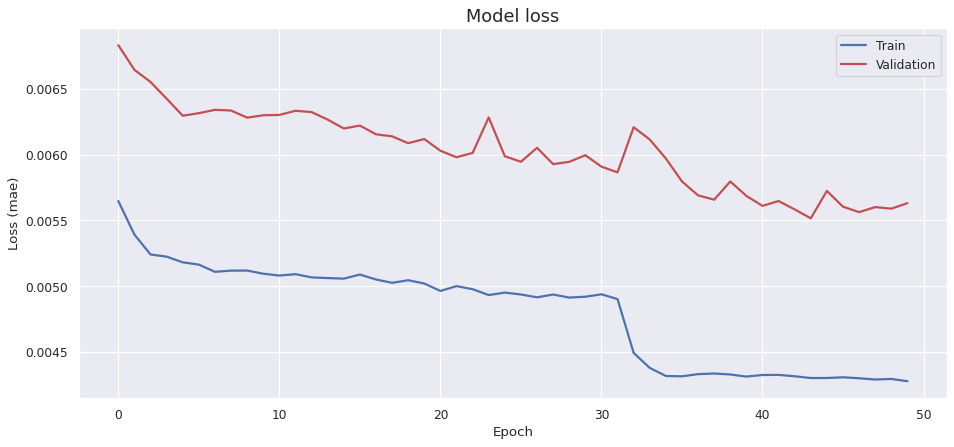

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2) #Доля ошибки на обучающем наборе
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2) #Доля ошибки на проверочном наборе
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [9]:
from tensorflow.keras.models import load_model

LTSV_model = load_model('/content/drive/MyDrive/model_3.h5')


График распределения рассчитанных потерь в обучающем наборе, можно использовать это для определения подходящего порогового значения для выявления аномалии.

29120/29120 [==============================] - 84s 3ms/step


<ipython-input-10-258f85f54d3d>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

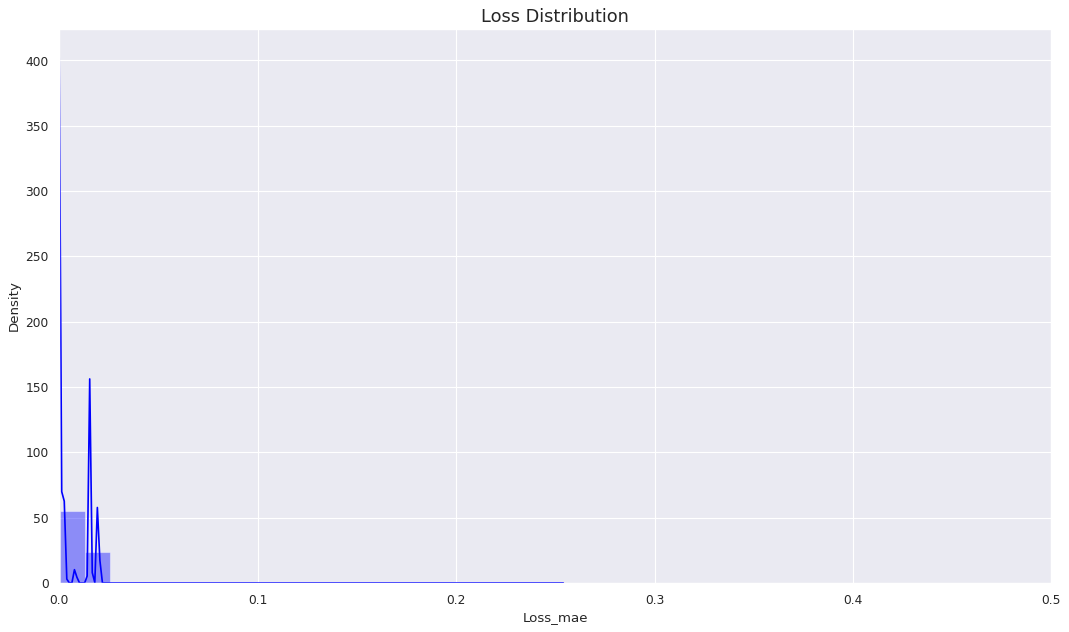

In [10]:
X_pred = LTSV_model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

Из приведенного выше распределения потерь попробуем установить пороговое значение 0,025 для обозначения аномалии. Затем рассчитаем потери в тестовом наборе, чтобы проверить, когда выходные данные пересекают порог аномалии.

In [18]:
X_pred = LTSV_model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index


7280/7280 [==============================] - 18s 2ms/step


In [20]:
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.025
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
anomaly_rows = scored[scored['Anomaly'] == True]
anomaly_rows

,Loss_mae,Threshold,Anomaly
932190,0.226484,0.025,True
937741,0.052858,0.025,True
937742,0.252471,0.025,True
946113,0.035924,0.025,True
946114,0.219804,0.025,True
949465,0.239239,0.025,True
951066,0.135222,0.025,True
964927,0.032320,0.025,True
967578,0.227357,0.025,True
973209,0.050060,0.025,True


In [23]:
pred = LTSV_model.predict(X_test)

7280/7280 [==============================] - 17s 2ms/step


Выполняет оценку MAE между фактическими данными (X_test_reshaped) и предсказанными данными (pred_reshaped). Среднее абсолютное отклонение на каждом временном шаге и для каждого признака = ранее выбрано моделью на этапе обучения, как оптимальное val_loss.

In [24]:
from sklearn.metrics import mean_absolute_error

#Для оценки нужно перевети в двухмерный массив
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
pred_reshaped = pred.reshape(-1, pred.shape[2])

mae = mean_absolute_error(X_test_reshaped, pred_reshaped)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.005515819430778662


# Тесты на данных с аномалиями

Для поиска оценки обработки аномалий были проведены следующие эксперементы. В качестстве датасета с аномалиями был применен массив данных с специально изменеными данными, сильно отличающимися от нормлаьных

In [27]:
df_anomaly_test = pd.read_csv('/content/drive/MyDrive/attack3.csv')

df_anomaly_test = df_anomaly_test.drop(columns = ['Info', 'No.'], axis=1)
df_anomaly_test = df_anomaly_test.replace("Missing", pd.NA)
df_anomaly_test = df_anomaly_test.replace("Offln", pd.NA)
df_anomaly_test = df_anomaly_test.dropna()

protocol_dummies = pd.get_dummies(df_anomaly_test['Protocol'], prefix='Protocol')
protocol_dummies = protocol_dummies.astype(int)

df_anomaly_test_encoded = pd.concat([df_anomaly_test, protocol_dummies], axis=1)
df_anomaly_test_encoded.drop(['Protocol'], axis=1, inplace=True)

df_anomaly_test_encoded['Source_scaled'] = df_anomaly_test_encoded['Source'].apply(scale_ip_addresses)
df_anomaly_test_encoded['Destination_scaled'] = df_anomaly_test_encoded['Destination'].apply(scale_ip_addresses)
df_anomaly_test_encoded['Source_scaled'] = df_anomaly_test_encoded['Source_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
df_anomaly_test_encoded['Destination_scaled'] = df_anomaly_test_encoded['Destination_scaled'].apply(lambda x: x + [0] * (8 - len(x)))

source_octets_df_anomaly_test = pd.DataFrame(df_anomaly_test_encoded['Source_scaled'].tolist(), columns=[f'Source_Octet{i}' for i in range(1, 9)])
destination_octets_df_anomaly_test = pd.DataFrame(df_anomaly_test_encoded['Destination_scaled'].tolist(), columns=[f'Destination_Octet{i}' for i in range(1, 9)])


df_anomaly_test_encoded = pd.concat([df_anomaly_test_encoded, source_octets_df_anomaly_test, destination_octets_df_anomaly_test], axis=1)
df_anomaly_test_encoded.drop(['Source_scaled', 'Destination_scaled', 'Source', 'Destination'], axis=1, inplace=True)
df_anomaly_test_encoded.fillna(0, inplace=True)


df_anomaly_test_encoded['Scaled_Time'] = (df_anomaly_test_encoded['Time'] - df_anomaly_test_encoded['Time'].shift(1)) / df_anomaly_test_encoded['Time'].diff().max()
df_anomaly_test_encoded['Scaled_Time'].fillna(0, inplace=True)
df_anomaly_test_encoded.drop(['Time'], axis=1, inplace=True)

#нормализует значения с использованием Min-Max Scaling
scaler3 = MinMaxScaler()
df_anomaly_test_encoded[['Length']] = scaler3.fit_transform(df_anomaly_test_encoded[['Length']])
df_anomaly_test_encoded[['Scaled_Time']] = scaler3.fit_transform(df_anomaly_test_encoded[['Scaled_Time']])


#нормализация данных
scaler4 = MinMaxScaler()
df_anomaly_test_scaled = scaler4.fit_transform(df_anomaly_test_encoded)
print("Normalize dataset:")
print(df_anomaly_test_scaled)

df_anomaly_test_shaped = df_anomaly_test_scaled.reshape(df_anomaly_test_scaled.shape[0], 1, df_anomaly_test_scaled.shape[1])
print("Data shape:", df_anomaly_test_shaped.shape)

Normalize dataset:
[[9.16030534e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 7.22256933e-06]
 [4.58015267e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 8.32601750e-06]
 [8.77862595e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.86896518e-05]
 ...
 [4.58015267e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.10971759e-05]
 [7.63358779e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.08662048e-03]
 [7.63358779e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.63009196e-06]]
Data shape: (1178259, 1, 22)


In [28]:
from tensorflow.keras.models import load_model

LTSV_model = load_model('/content/drive/MyDrive/model_3.h5')

X_pred_anomaly = LTSV_model.predict(df_anomaly_test_shaped)


36821/36821 [==============================] - 89s 2ms/step


In [29]:
X_pred_anomaly = X_pred_anomaly.reshape(-1, X_pred_anomaly.shape[2])

In [31]:
scored = pd.DataFrame(index=df_anomaly_test_encoded.index)
Xtest_anomaly = df_anomaly_test_shaped.reshape(df_anomaly_test_shaped.shape[0], df_anomaly_test_shaped.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred_anomaly-Xtest_anomaly), axis = 1)
scored['Threshold'] = 0.025
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
anomaly_rows = scored[scored['Anomaly'] == True]
anomaly_rows

,Loss_mae,Threshold,Anomaly
16,0.035290,0.025,True
61,0.035308,0.025,True
106,0.035360,0.025,True
151,0.035309,0.025,True
196,0.035325,0.025,True
...,...,...,...
1178043,0.035325,0.025,True
1178088,0.035306,0.025,True
1178133,0.035306,0.025,True
1178178,0.035323,0.025,True


In [32]:
scored_train = pd.DataFrame(index=df_anomaly_test_encoded.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_anomaly-Xtest_anomaly), axis = 1)
scored_train['Threshold'] = 0.025
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<Axes: >

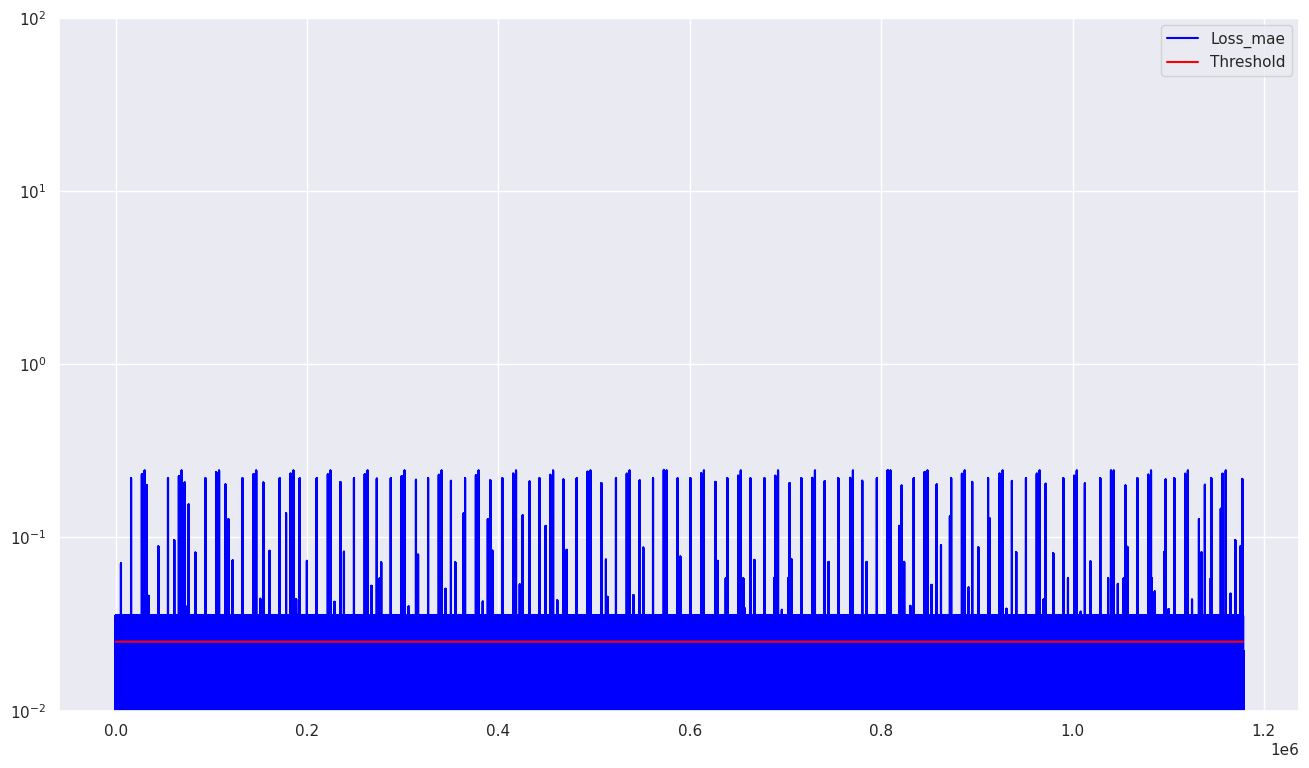

In [33]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

## Z-оценки

Сменим подход и теперь будем вычислять разницу между предсказаными и тестовыми значениями, затем с помощью среднего значения, и вычисления z-оценок для каждого элемента подмассива найдем аномалии, тое сть наиболее отличающиеся разницы массивов X_test и diff

In [36]:
df_anomaly_test_reshaped = df_anomaly_test_shaped.reshape(-1, df_anomaly_test_shaped.shape[2])

diff = np.abs(df_anomaly_test_reshaped - X_pred_anomaly)
diff.shape

(1178259, 22)

In [37]:
mean_value = sum(diff) / len(diff)

print(f"Среднее значение: {mean_value}")

Среднее значение: [4.15534432e-02 9.69045026e-05 1.86298540e-04 6.00486172e-04
 6.97779646e-04 1.16624615e-05 1.17068822e-04 7.25254362e-05
 2.44598230e-01 1.60761239e-04 1.50147158e-04 3.71312733e-04
 2.18961166e-04 7.58399249e-05 3.47383121e-04 6.51425126e-05
 4.65532900e-03 1.50730882e-04 1.31788593e-04 2.68426079e-04
 6.06372841e-05 9.30211865e-03]


In [39]:
#Z-оценки для каждого элемента каждого подмассива
z_scores = (diff - mean_value) / np.std(diff, axis=0)

#сумма абсолютных Z-оценок для каждого подмассива
sum_z_scores = np.sum(np.abs(z_scores), axis=1)

#нахождение наиболее отличающихся, можно настроить вывод, в данном случае топ 5 отличающихся
top_indices = np.argsort(sum_z_scores)[-50:]
for index in top_indices:
    print(f"Отличающийся подмассив {index + 1}: {diff[index]}")

Отличающийся подмассив 575780: [0.17239828 0.02845045 0.06862712 0.01956118 0.01114661 0.01673317
 0.01107532 0.03069001 0.01445732 0.04620136 0.08406955 0.00616645
 0.09427291 0.02772045 0.00632364 0.02871746 0.00532693 0.0296976
 0.0258255  0.0319947  0.06108987 0.03495883]
Отличающийся подмассив 692193: [0.17239828 0.02845045 0.06862712 0.01956118 0.01114661 0.01673317
 0.01107532 0.03069001 0.01445732 0.04620136 0.08406955 0.00616645
 0.09427291 0.02772045 0.00632364 0.02871746 0.00532693 0.0296976
 0.0258255  0.0319947  0.06108987 0.03495883]
Отличающийся подмассив 379318: [0.17239828 0.02845045 0.06862712 0.01956118 0.01114661 0.01673317
 0.01107532 0.03069001 0.01445732 0.04620136 0.08406955 0.00616645
 0.09427291 0.02772045 0.00632364 0.02871746 0.00532693 0.0296976
 0.0258255  0.0319947  0.06108987 0.03495883]
Отличающийся подмассив 730814: [0.17239828 0.02845045 0.06862712 0.01956118 0.01114661 0.01673317
 0.01107532 0.03069001 0.01445732 0.04620136 0.08406955 0.00616645
 0.0

In [40]:
selected_rows = df_anomaly_test.loc[top_indices]

# Выведем результат
print(selected_rows)

                  Time                     Source Destination Protocol  Length
575779    53200.814805    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
692192    64000.858822    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
379317    35200.737139    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
730813    67600.870833    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
1004531   92800.954885    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
927023    85600.931230    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
1120614  103600.986082    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
68861      6400.656155    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
496088    46000.782794    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
185604    17200.657623    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
301749    28000.711001    fe80::42:f9ff:fe49:f009    ff02::fb     MDNS     180
146709    13600.657119    fe80::42:f9ff:fe49:f009   

## Проблемы

Существует пробелма протоколов, если будут найены или наоборот не найдены протоклы на которых обучалась можель то предсказанпя сделать будет нельзя

Нахождение порога для mse, предложенное решение перебрать пороги от 0 до 1 и на нескольких датасетов найти оптимальный порог

Если модель обучена на недостаточно разнообразных данных, то при поиске аномалий такие явления как адреса ipv6 будут являтся аномалией на фоне ipv4


Аналаиз по ырееннымс рядам здесь затруднен из за специфики данных